# Train Change Classifier (DETR + Hungarian + Logistic Regression)

This script trains a **binary classifier** to decide whether a change between two floorplan images is:

- **0 = non_substantial** (non-significant change)
- **1 = substantial** (significant change)

It uses:
- **DETR** to detect objects in the BEFORE and AFTER images
- **Hungarian Matching** to align detections between the two images
- A small **Logistic Regression** model to classify the change based on extracted matching features

---

## Inputs

### 1) Synthetic dataset structure
The script expects a dataset like:

- `..\Data\images_before\..`
- `..\Data\images_after\..`
- `..\Data\metadata.jsonl`

### 2) metadata.jsonl
Each line in the JSONL should contain at least:
- `src_image` (path to BEFORE image)
- `out_image` (path to AFTER image)
- `group` (`"substantial"` or `"non_substantial"`)
- `status` should be `"ok"`

The label is created as:
- `y = 1` if `group == "substantial"`
- `y = 0` otherwise

---

## Pipeline Overview

### Step 1 — Load Pairs
Pairs are loaded from `metadata.jsonl` into a list of:

- before_path
- after_path
- y (0/1 label)
- group/change metadata

---

### Step 2 — Run DETR on Each Image (with cache)
For every image, the script runs DETR and stores results as:

- label_id
- score
- bounding box (xyxy)

To speed up reruns, detections are cached to disk.

---

### Step 3 — Hungarian Matching (BEFORE ↔ AFTER)
Detections are aligned using **Hungarian matching** with a cost function:

`cost = (1 - IoU) + label_mismatch_penalty + center_distance_penalty`

Where:
- `IoU` compares bounding box overlap
- `LABEL_MISMATCH_PENALTY` penalizes matching different classes
- `CENTER_DIST_PENALTY` penalizes far objects

---

### Step 4 — Feature Extraction
From the matching results, a compact feature vector is computed:

- `global_sim` — sum IoU normalized by max(#dets_before, #dets_after)
- `mean_iou`
- `min_iou`
- `mean_cost`
- `mismatch_frac` — fraction of matched pairs with different labels
- `unmatched_ratio` — how many detections could not be matched

---

### Step 5 — Train a Classifier
A **Logistic Regression** classifier is trained using these features:

- input: feature vectors for all pairs
- output: 0/1 (non_substantial / substantial)

Validation uses a group split by `src_stem` to reduce leakage.

---

## Outputs (What the Script Saves)

The script creates and uses the folder:



In [ ]:
import os
import json
import pickle
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
from PIL import Image

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

from scipy.optimize import linear_sum_assignment

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit


# =========================
# CONFIG
# =========================
# We assume this script runs from the 'Code' folder, so we go up one level
PROJECT_ROOT = ".."

# Path to the metadata generated by your previous script
METADATA_JSONL = os.path.join(PROJECT_ROOT, "synthetic_dataset", "metadata.jsonl")

# Path to the DETR model (Checking both flat and nested structures to be safe)
_model_flat = os.path.join(PROJECT_ROOT, "Models", "detr-finetuned-floorplans")
_model_nested = os.path.join(PROJECT_ROOT, "Models", "detr-finetuned-floorplans", "detr-finetuned-floorplans")

if os.path.exists(_model_nested):
    DETR_MODEL_PATH = _model_nested
elif os.path.exists(_model_flat):
    DETR_MODEL_PATH = _model_flat
else:
    # Fallback to flat if neither exists (will raise error later)
    DETR_MODEL_PATH = _model_flat

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DETR_THRESH = 0.25
TOP_K = 60

# Matching hyperparams
LABEL_MISMATCH_PENALTY = 0.8   # Penalty cost for matching different labels
CENTER_DIST_PENALTY = 0.15     # Penalty for center distance

# Cache - Saving inside Models folder to keep project clean
CACHE_DIR = os.path.join(PROJECT_ROOT, "Models", "ChangeTypeClassifier", "_cache")
os.makedirs(CACHE_DIR, exist_ok=True)
DETS_CACHE_PATH = os.path.join(CACHE_DIR, "dets_cache.pkl")
FEAT_CACHE_PATH = os.path.join(CACHE_DIR, "features_cache.pkl")

RANDOM_SEED = 42


# =========================
# Utils
# =========================
def _norm_path(p: str) -> str:
    """Normalize windows-like paths from metadata to current OS path."""
    p = p.replace("\\", os.sep).replace("/", os.sep)
    # If the path is relative, join it with PROJECT_ROOT
    return os.path.join(PROJECT_ROOT, p) if not os.path.isabs(p) else p


def xyxy_iou(a: np.ndarray, b: np.ndarray) -> float:
    """a,b: (4,) xyxy"""
    ax0, ay0, ax1, ay1 = a
    bx0, by0, bx1, by1 = b
    inter_x0 = max(ax0, bx0)
    inter_y0 = max(ay0, by0)
    inter_x1 = min(ax1, bx1)
    inter_y1 = min(ay1, by1)
    iw = max(0.0, inter_x1 - inter_x0)
    ih = max(0.0, inter_y1 - inter_y0)
    inter = iw * ih
    area_a = max(0.0, ax1 - ax0) * max(0.0, ay1 - ay0)
    area_b = max(0.0, bx1 - bx0) * max(0.0, by1 - by0)
    union = area_a + area_b - inter + 1e-9
    return float(inter / union)


def bbox_center(box: np.ndarray) -> np.ndarray:
    x0, y0, x1, y1 = box
    return np.array([(x0 + x1) / 2.0, (y0 + y1) / 2.0], dtype=np.float32)


@dataclass
class Det:
    label_id: int
    score: float
    box_xyxy: np.ndarray  # (4,)


# =========================
# DETR inference (cached)
# =========================
class DetrDetector:
    def __init__(self, model_path: str, device: str):
        self.device = device
        print(f"Loading DETR from: {model_path}")
        self.processor = DetrImageProcessor.from_pretrained(model_path)
        self.model = DetrForObjectDetection.from_pretrained(model_path).to(device).eval()

    @torch.no_grad()
    def detect(self, image_path: str, score_thresh: float = 0.25, top_k: int = 60) -> List[Det]:
        img = Image.open(image_path).convert("RGB")
        inputs = self.processor(images=img, return_tensors="pt").to(self.device)
        outputs = self.model(**inputs)

        target_sizes = torch.tensor([img.size[::-1]], device=self.device)  # (h,w)
        results = self.processor.post_process_object_detection(
            outputs, threshold=0.0, target_sizes=target_sizes
        )[0]

        scores = results["scores"].detach().cpu().numpy()
        labels = results["labels"].detach().cpu().numpy()
        boxes = results["boxes"].detach().cpu().numpy()  # xyxy float

        # filter by thresh + top_k
        keep = np.where(scores >= score_thresh)[0]
        if keep.size == 0:
            return []

        keep = keep[np.argsort(scores[keep])[::-1]]
        keep = keep[:top_k]

        dets = []
        for i in keep:
            dets.append(
                Det(
                    label_id=int(labels[i]),
                    score=float(scores[i]),
                    box_xyxy=boxes[i].astype(np.float32),
                )
            )
        return dets


def load_or_init_pickle(path: str) -> dict:
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return {}


def save_pickle(path: str, obj: dict) -> None:
    with open(path, "wb") as f:
        pickle.dump(obj, f)


# =========================
# Hungarian matching + features
# =========================

def build_cost_matrix(dets_a: List[Det], dets_b: List[Det], img_wh: Tuple[int, int]) -> np.ndarray:
    """
    cost(i,j) = (1 - IoU) + label_penalty + center_penalty
    """
    w, h = img_wh
    diag = (w**2 + h**2) ** 0.5 + 1e-9

    A = len(dets_a)
    B = len(dets_b)
    if A == 0 or B == 0:
        return np.zeros((A, B), dtype=np.float32)

    cost = np.zeros((A, B), dtype=np.float32)
    for i, da in enumerate(dets_a):
        ca = bbox_center(da.box_xyxy)
        for j, db in enumerate(dets_b):
            iou = xyxy_iou(da.box_xyxy, db.box_xyxy)
            base = 1.0 - iou

            label_pen = 0.0 if da.label_id == db.label_id else LABEL_MISMATCH_PENALTY

            cb = bbox_center(db.box_xyxy)
            center_dist = float(np.linalg.norm(ca - cb) / diag)
            center_pen = CENTER_DIST_PENALTY * center_dist

            cost[i, j] = base + label_pen + center_pen

    return cost


def hungarian_match(
    dets_a: List[Det], dets_b: List[Det], img_wh: Tuple[int, int]
) -> Tuple[List[Tuple[int, int]], List[int], List[int], np.ndarray]:
    """
    Returns:
      matches: list of (i,j)
      unmatched_a: indices in A
      unmatched_b: indices in B
      cost_matrix
    """
    A, B = len(dets_a), len(dets_b)
    if A == 0 and B == 0:
        return [], [], [], np.zeros((0, 0), dtype=np.float32)
    if A == 0:
        return [], [], list(range(B)), np.zeros((0, B), dtype=np.float32)
    if B == 0:
        return [], list(range(A)), [], np.zeros((A, 0), dtype=np.float32)

    cost = build_cost_matrix(dets_a, dets_b, img_wh)
    row_ind, col_ind = linear_sum_assignment(cost)

    matches = list(zip(row_ind.tolist(), col_ind.tolist()))

    matched_a = set(row_ind.tolist())
    matched_b = set(col_ind.tolist())
    unmatched_a = [i for i in range(A) if i not in matched_a]
    unmatched_b = [j for j in range(B) if j not in matched_b]

    return matches, unmatched_a, unmatched_b, cost


def extract_pair_features(
    dets_before: List[Det],
    dets_after: List[Det],
    img_wh: Tuple[int, int],
) -> np.ndarray:
    """
    Returns a small feature vector derived from the matching.
    Does not explicitly calculate "what changed", but measures dissimilarity.
    """
    matches, un_bef, un_aft, cost = hungarian_match(dets_before, dets_after, img_wh)

    # Similarity: sum IoU over matches, normalized by max(lenA,lenB)
    # (unmatched contribute 0 IoU implicitly)
    if len(matches) > 0:
        ious = []
        label_mismatch = 0
        for i, j in matches:
            iou = xyxy_iou(dets_before[i].box_xyxy, dets_after[j].box_xyxy)
            ious.append(iou)
            if dets_before[i].label_id != dets_after[j].label_id:
                label_mismatch += 1
        ious = np.array(ious, dtype=np.float32)
        mean_iou = float(ious.mean())
        min_iou = float(ious.min())
        mean_cost = float(np.mean([cost[i, j] for (i, j) in matches]))
        mismatch_frac = float(label_mismatch / max(1, len(matches)))
    else:
        mean_iou = 0.0
        min_iou = 0.0
        mean_cost = 1.0
        mismatch_frac = 1.0

    denom = float(max(len(dets_before), len(dets_after), 1))
    sum_iou = 0.0
    for i, j in matches:
        sum_iou += xyxy_iou(dets_before[i].box_xyxy, dets_after[j].box_xyxy)
    global_sim = float(sum_iou / denom)  # 1=identical-ish, 0=very different

    # Unmatched penalty as a *ratio* (basic robustness)
    unmatched_ratio = float((len(un_bef) + len(un_aft)) / denom)

    # Feature vector
    feats = np.array(
        [global_sim, mean_iou, min_iou, mean_cost, mismatch_frac, unmatched_ratio],
        dtype=np.float32,
    )
    return feats


# =========================
# Metadata -> pairs
# =========================
def load_pairs_from_metadata(jsonl_path: str) -> List[Dict[str, Any]]:
    pairs = []
    if not os.path.exists(jsonl_path):
        print(f"Error: Metadata file not found at {jsonl_path}")
        return []

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            ex = json.loads(line)
            if ex.get("status") != "ok":
                continue

            before_path = _norm_path(ex["src_image"])
            after_path = _norm_path(ex["out_image"])
            group = ex.get("group", "non_substantial")
            y = 1 if group == "substantial" else 0

            pairs.append(
                {
                    "before": before_path,
                    "after": after_path,
                    "y": y,
                    "group": group,
                    "change": ex.get("change", ""),
                    "src_stem": ex.get("src_stem", os.path.basename(before_path)),
                }
            )
    return pairs


# =========================
# Main train
# =========================
def main():
    print("DEVICE:", DEVICE)
    print("Loading metadata:", METADATA_JSONL)

    pairs = load_pairs_from_metadata(METADATA_JSONL)
    print("Pairs found:", len(pairs))

    if not pairs:
        print("No pairs found. Check if metadata.jsonl exists and contains 'status': 'ok'.")
        return

    # Split by src_stem to reduce leakage
    groups = np.array([p["src_stem"] for p in pairs])
    y = np.array([p["y"] for p in pairs], dtype=np.int64)

    # Handle case with too few samples for split
    if len(pairs) < 5:
        print("Dataset too small for split, using all for training.")
        train_pairs = pairs
        val_pairs = pairs
    else:
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
        train_idx, val_idx = next(splitter.split(np.zeros(len(pairs)), y, groups=groups))
        train_pairs = [pairs[i] for i in train_idx]
        val_pairs = [pairs[i] for i in val_idx]

    print("Train:", len(train_pairs), "Val:", len(val_pairs))

    # Load caches
    dets_cache: Dict[str, List[Det]] = load_or_init_pickle(DETS_CACHE_PATH)
    feat_cache: Dict[Tuple[str, str], np.ndarray] = load_or_init_pickle(FEAT_CACHE_PATH)

    detector = DetrDetector(DETR_MODEL_PATH, DEVICE)

    def get_dets(img_path: str) -> List[Det]:
        if img_path in dets_cache:
            return dets_cache[img_path]
        
        if not os.path.exists(img_path):
            print(f"Warning: Image not found {img_path}")
            return []

        dets = detector.detect(img_path, score_thresh=DETR_THRESH, top_k=TOP_K)
        dets_cache[img_path] = dets
        return dets

    def get_feats(before_path: str, after_path: str) -> np.ndarray:
        key = (before_path, after_path)
        if key in feat_cache:
            return feat_cache[key]

        if not os.path.exists(before_path):
            return np.zeros(6, dtype=np.float32)

        # Need image size for center normalization
        img = Image.open(before_path).convert("RGB")
        img_wh = img.size  # (w,h)

        det_b = get_dets(before_path)
        det_a = get_dets(after_path)
        feats = extract_pair_features(det_b, det_a, img_wh)
        feat_cache[key] = feats
        return feats

    # Build X
    def build_xy(pair_list: List[Dict[str, Any]]):
        X_list = []
        y_list = []
        for p in pair_list:
            bp, ap = p["before"], p["after"]
            feats = get_feats(bp, ap)
            X_list.append(feats)
            y_list.append(p["y"])
        
        if not X_list:
            return np.array([]), np.array([])
            
        return np.stack(X_list, axis=0), np.array(y_list, dtype=np.int64)

    print("Extracting features (with cache)...")
    X_train, y_train = build_xy(train_pairs)
    X_val, y_val = build_xy(val_pairs)

    # Save caches
    save_pickle(DETS_CACHE_PATH, dets_cache)
    save_pickle(FEAT_CACHE_PATH, feat_cache)

    if len(X_train) == 0:
        print("No training data generated.")
        return

    # Train classifier
    
    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_SEED,
    )
    clf.fit(X_train, y_train)

    # Eval
    if len(X_val) > 0:
        val_pred = clf.predict(X_val)
        print("\n=== VAL REPORT ===")
        print(classification_report(y_val, val_pred, digits=4, zero_division=0))
        print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

    # Save model
    model_out = os.path.join(CACHE_DIR, "change_classifier_logreg.pkl")
    with open(model_out, "wb") as f:
        pickle.dump(
            {
                "clf": clf,
                "detr_model_path": DETR_MODEL_PATH,
                "detr_thresh": DETR_THRESH,
                "top_k": TOP_K,
                "feature_names": ["global_sim", "mean_iou", "min_iou", "mean_cost", "mismatch_frac", "unmatched_ratio"],
            },
            f,
        )
    print("\nSaved:", model_out)

    # Quick demo on one val sample
    if len(val_pairs) > 0:
        demo = val_pairs[0]
        prob = clf.predict_proba(get_feats(demo["before"], demo["after"]).reshape(1, -1))[0, 1]
        print("\nDemo:")
        print("change:", demo["change"], "group:", demo["group"], "y:", demo["y"])
        print("P(substantial) =", float(prob))


if __name__ == "__main__":
    main()

c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda
Loading metadata: .\synthetic_dataset\metadata.jsonl
Pairs: 3264
Train: 2578 Val: 686


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

Extracting features (with cache)...

=== VAL REPORT ===
              precision    recall  f1-score   support

           0     0.6384    0.7508    0.6901       301
           1     0.7741    0.6675    0.7169       385

    accuracy                         0.7041       686
   macro avg     0.7063    0.7092    0.7035       686
weighted avg     0.7146    0.7041    0.7051       686

Confusion matrix:
 [[226  75]
 [128 257]]

Saved: .\_cache_change_cls\change_classifier_logreg.pkl

Demo:
change: remove_stove group: substantial y: 1
P(substantial) = 0.6140036965080224


# DETR + Hungarian (Rule-Based) Change Classifier + Visualization

This script compares **two floorplan images** (BEFORE / AFTER) and predicts whether the change is:

- **SIGNIFICANT (1)** — substantial change  
- **NON-SIGNIFICANT (0)** — minor or no change

It uses:
- **DETR** for object detection on each image
- **Hungarian matching** to align detections between BEFORE and AFTER
- **Rule-based logic** (no training) to decide if the change is significant
- **Matplotlib visualization** to show both images side-by-side with bounding boxes and the final prediction label

---

## Folder / Paths Assumptions

Make sure your project contains:

- `..\Models\detr-finetuned-floorplans` (your fine-tuned DETR model)
- `..\Data\images_before\...`
- `..\Data\images_after\...`

---

## How to Use

1. Open the script and set the pair paths:

```python
BEFORE = r"<img>"
AFTER  = r"<img>"
```

DEVICE: cuda
BEFORE: synthetic_dataset\images_before\image_248.png
AFTER : synthetic_dataset\images_after\non-substantial\remove_closet\image_248_242_synthetic.png

RESULT: 0 => NON-SIGNIFICANT
DEBUG: {'sig_removed_idxs': [], 'sig_added_idxs': [], 'sig_changed_pairs': [], 'params': {'DETR_THRESH': 0.2, 'TOP_K': 80, 'SIG_SCORE_MIN': 0.5, 'MATCH_MAX_COST': 1.25, 'SIGNIFICANT_IOU_MIN': 0.2, 'SIG_CLASSES': ['sink', 'stove', 'toilet']}}


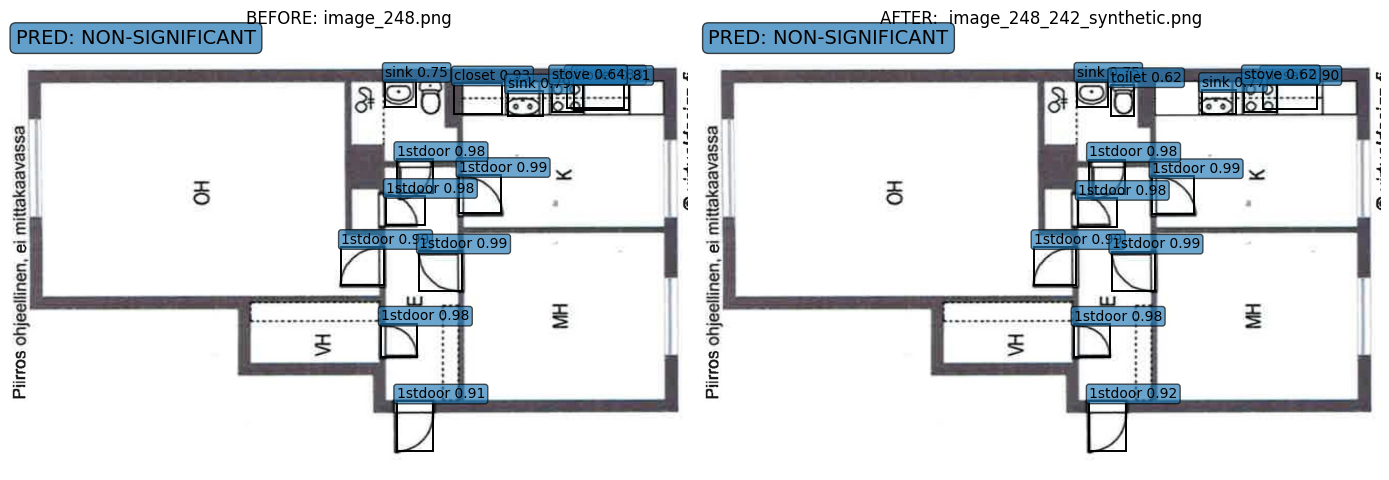

In [ ]:
import os
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import torch
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# =========================
# CONFIGURATION
# =========================

# Path to the specific pair you want to test (relative to Code folder)
# Make sure these files exist. The 'after' file depends on what was generated.
BEFORE = r"..\Data\images_before\image_022.jpg"
AFTER  = r"..\Data\images_after\substantial\remove_stove\image_022_0_synthetic.jpg"

# Path to the model (relative to Code folder)
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Detection
DETR_THRESH = 0.20
TOP_K = 80

# Matching cost
LABEL_MISMATCH_PENALTY = 1.0
CENTER_DIST_PENALTY = 0.15

# Decision thresholds
MATCH_MAX_COST = 1.25
SIGNIFICANT_IOU_MIN = 0.20

# Gate "significant" decisions by confidence to reduce false positives
SIG_SCORE_MIN = 0.50 

# Update these names according to your model's id2label
SIGNIFICANT_CLASS_NAMES = {"sink", "toilet", "stove"}

# Visualization
SHOW_VIZ = True
SAVE_VIZ_PATH = None               # e.g. "pair_debug.png" or None
FIGSIZE = (14, 7)

# Draw all detections options
DRAW_ALL_DETECTIONS = True
DRAW_ALL_MIN_SCORE = 0.60          # show only detections above this score
ALL_DET_LINEWIDTH = 1.4
HIGHLIGHT_LINEWIDTH = 3.0

# Debug options
PRINT_ID2LABEL_ON_START = False    # set True once to see model labels


# =========================
# Data structure
# =========================
@dataclass
class Det:
    label_id: int
    label_name: str
    score: float
    box: np.ndarray  # xyxy float


# =========================
# Geometry helpers
# =========================
def iou_xyxy(a: np.ndarray, b: np.ndarray) -> float:
    ax0, ay0, ax1, ay1 = a
    bx0, by0, bx1, by1 = b
    inter_x0 = max(ax0, bx0)
    inter_y0 = max(ay0, by0)
    inter_x1 = min(ax1, bx1)
    inter_y1 = min(ay1, by1)
    iw = max(0.0, inter_x1 - inter_x0)
    ih = max(0.0, inter_y1 - inter_y0)
    inter = iw * ih
    area_a = max(0.0, ax1 - ax0) * max(0.0, ay1 - ay0)
    area_b = max(0.0, bx1 - bx0) * max(0.0, by1 - by0)
    union = area_a + area_b - inter + 1e-9
    return float(inter / union)


def center(box: np.ndarray) -> np.ndarray:
    x0, y0, x1, y1 = box
    return np.array([(x0 + x1) / 2.0, (y0 + y1) / 2.0], dtype=np.float32)


# =========================
# DETR wrapper
# =========================
class DetrWrapper:
    def __init__(self, model_path: str, device: str):
        self.device = device
        self.processor = DetrImageProcessor.from_pretrained(model_path)
        self.model = DetrForObjectDetection.from_pretrained(model_path).to(device).eval()
        self.id2label: Dict[int, str] = self.model.config.id2label

    @torch.no_grad()
    def detect(self, image_path: str, thresh: float, top_k: int) -> Tuple[List[Det], Tuple[int, int]]:
        img = Image.open(image_path).convert("RGB")
        w, h = img.size

        inputs = self.processor(images=img, return_tensors="pt").to(self.device)
        outputs = self.model(**inputs)

        target_sizes = torch.tensor([[h, w]], device=self.device)
        res = self.processor.post_process_object_detection(
            outputs, threshold=0.0, target_sizes=target_sizes
        )[0]

        scores = res["scores"].detach().cpu().numpy()
        labels = res["labels"].detach().cpu().numpy()
        boxes = res["boxes"].detach().cpu().numpy()

        keep = np.where(scores >= thresh)[0]
        if keep.size == 0:
            return [], (w, h)

        keep = keep[np.argsort(scores[keep])[::-1]]
        keep = keep[:top_k]

        dets: List[Det] = []
        for i in keep:
            lid = int(labels[i])
            dets.append(
                Det(
                    label_id=lid,
                    label_name=str(self.id2label.get(lid, lid)),
                    score=float(scores[i]),
                    box=boxes[i].astype(np.float32),
                )
            )
        return dets, (w, h)


# =========================
# Hungarian matching
# =========================
def build_cost(
    dets_a: List[Det],
    dets_b: List[Det],
    img_wh: Tuple[int, int],
    label_pen: float,
    center_pen: float,
) -> np.ndarray:
    w, h = img_wh
    diag = (w * w + h * h) ** 0.5 + 1e-9

    A, B = len(dets_a), len(dets_b)
    cost = np.zeros((A, B), dtype=np.float32)

    for i, da in enumerate(dets_a):
        ca = center(da.box)
        for j, db in enumerate(dets_b):
            base = 1.0 - iou_xyxy(da.box, db.box)
            lp = 0.0 if da.label_id == db.label_id else label_pen
            cb = center(db.box)
            dp = center_pen * float(np.linalg.norm(ca - cb) / diag)
            cost[i, j] = base + lp + dp
    return cost


def hungarian(
    dets_a: List[Det],
    dets_b: List[Det],
    img_wh: Tuple[int, int],
    label_pen: float,
    center_pen: float,
):
    A, B = len(dets_a), len(dets_b)
    if A == 0 or B == 0:
        return [], list(range(A)), list(range(B)), None

    cost = build_cost(dets_a, dets_b, img_wh, label_pen, center_pen)
    r, c = linear_sum_assignment(cost)

    matches = list(zip(r.tolist(), c.tolist()))
    matched_a = set(r.tolist())
    matched_b = set(c.tolist())
    un_a = [i for i in range(A) if i not in matched_a]
    un_b = [j for j in range(B) if j not in matched_b]
    return matches, un_a, un_b, cost


# =========================
# Visualization helpers
# =========================
def _draw_box(ax, box_xyxy, text: str, linewidth: float):
    x0, y0, x1, y1 = box_xyxy
    rect = Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, linewidth=linewidth)
    ax.add_patch(rect)
    if text:
        ax.text(
            x0, max(0, y0 - 6),
            text,
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.2", alpha=0.65),
        )


def visualize_pair(
    before_path: str,
    after_path: str,
    pred_label: int,
    dbg: Dict[str, Any],
    det_b: List[Det],
    det_a: List[Det],
):
    img_b = Image.open(before_path).convert("RGB")
    img_a = Image.open(after_path).convert("RGB")

    fig = plt.figure(figsize=FIGSIZE)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.imshow(img_b)
    ax2.imshow(img_a)

    ax1.axis("off")
    ax2.axis("off")

    ax1.set_title(f"BEFORE: {os.path.basename(before_path)}")
    ax2.set_title(f"AFTER:  {os.path.basename(after_path)}")

    pred_text = "SIGNIFICANT" if pred_label == 1 else "NON-SIGNIFICANT"

    ax1.text(10, 20, f"PRED: {pred_text}", fontsize=14,
             bbox=dict(boxstyle="round,pad=0.3", alpha=0.7))
    ax2.text(10, 20, f"PRED: {pred_text}", fontsize=14,
             bbox=dict(boxstyle="round,pad=0.3", alpha=0.7))

    # ---- Draw ALL detections (light) so you can see what DETR thinks
    if DRAW_ALL_DETECTIONS:
        for d in det_b:
            if d.score >= DRAW_ALL_MIN_SCORE:
                _draw_box(ax1, d.box, f"{d.label_name} {d.score:.2f}", linewidth=ALL_DET_LINEWIDTH)
        for d in det_a:
            if d.score >= DRAW_ALL_MIN_SCORE:
                _draw_box(ax2, d.box, f"{d.label_name} {d.score:.2f}", linewidth=ALL_DET_LINEWIDTH)

    # ---- Highlight ONLY what the change-decision used
    for idx in dbg["sig_removed_idxs"]:
        d = det_b[idx]
        _draw_box(ax1, d.box, f"REMOVED: {d.label_name} {d.score:.2f}", linewidth=HIGHLIGHT_LINEWIDTH)

    for idx in dbg["sig_added_idxs"]:
        d = det_a[idx]
        _draw_box(ax2, d.box, f"ADDED: {d.label_name} {d.score:.2f}", linewidth=HIGHLIGHT_LINEWIDTH)

    for item in dbg["sig_changed_pairs"]:
        i = item["before_idx"]
        j = item["after_idx"]
        reasons = ", ".join(item["reasons"])
        db = det_b[i]
        da = det_a[j]
        _draw_box(ax1, db.box, f"CHG: {db.label_name} {db.score:.2f}", linewidth=HIGHLIGHT_LINEWIDTH)
        _draw_box(ax2, da.box, f"CHG: {da.label_name} {da.score:.2f}\n{reasons}", linewidth=HIGHLIGHT_LINEWIDTH)

    plt.tight_layout()

    if SAVE_VIZ_PATH:
        os.makedirs(os.path.dirname(SAVE_VIZ_PATH), exist_ok=True)
        plt.savefig(SAVE_VIZ_PATH, dpi=150, bbox_inches="tight")
        print("Saved visualization to:", SAVE_VIZ_PATH)

    if SHOW_VIZ:
        plt.show()
    else:
        plt.close(fig)


# =========================
# Rule-based decision
# =========================
def predict_significant(
    detr: DetrWrapper,
    before_path: str,
    after_path: str,
    sig_classes: set,
    thresh: float,
    top_k: int,
    match_max_cost: float,
    sig_iou_min: float,
    label_pen: float,
    center_pen: float,
) -> Tuple[int, Dict[str, Any], List[Det], List[Det]]:
    det_b, wh_b = detr.detect(before_path, thresh=thresh, top_k=top_k)
    det_a, wh_a = detr.detect(after_path, thresh=thresh, top_k=top_k)
    img_wh = wh_b

    def is_sig(d: Det) -> bool:
        return d.label_name in sig_classes

    matches, un_b, un_a, cost = hungarian(det_b, det_a, img_wh, label_pen, center_pen)

    dbg: Dict[str, Any] = {
        "sig_removed_idxs": [],
        "sig_added_idxs": [],
        "sig_changed_pairs": [],
        "params": {
            "DETR_THRESH": thresh,
            "TOP_K": top_k,
            "SIG_SCORE_MIN": SIG_SCORE_MIN,
            "MATCH_MAX_COST": match_max_cost,
            "SIGNIFICANT_IOU_MIN": sig_iou_min,
            "SIG_CLASSES": sorted(list(sig_classes)),
        }
    }

    # 1) Significant added/removed only if confidence is high enough (SIG_SCORE_MIN)
    for i in un_b:
        d = det_b[i]
        if is_sig(d) and d.score >= SIG_SCORE_MIN:
            dbg["sig_removed_idxs"].append(i)

    for j in un_a:
        d = det_a[j]
        if is_sig(d) and d.score >= SIG_SCORE_MIN:
            dbg["sig_added_idxs"].append(j)

    if dbg["sig_removed_idxs"] or dbg["sig_added_idxs"]:
        return 1, dbg, det_b, det_a

    # 2) Significant "changed" matches (also require decent confidence)
    for (i, j) in matches:
        dbef, daft = det_b[i], det_a[j]
        if not (is_sig(dbef) or is_sig(daft)):
            continue

        # if both are low confidence, ignore
        if max(dbef.score, daft.score) < SIG_SCORE_MIN:
            continue

        pair_cost = float(cost[i, j]) if cost is not None else 999.0
        pair_iou = iou_xyxy(dbef.box, daft.box)

        reasons = []
        if pair_cost > match_max_cost:
            reasons.append(f"high_cost={pair_cost:.2f}")
        if dbef.label_id != daft.label_id:
            reasons.append("label_mismatch")
        if pair_iou < sig_iou_min:
            reasons.append(f"low_iou={pair_iou:.2f}")

        if reasons:
            dbg["sig_changed_pairs"].append({"before_idx": i, "after_idx": j, "reasons": reasons})

    if dbg["sig_changed_pairs"]:
        return 1, dbg, det_b, det_a

    return 0, dbg, det_b, det_a


def main():
    print("DEVICE:", DEVICE)
    print("BEFORE:", BEFORE)
    print("AFTER :", AFTER)

    if not os.path.exists(BEFORE):
        raise FileNotFoundError(f"BEFORE not found: {BEFORE}")
    if not os.path.exists(AFTER):
        raise FileNotFoundError(f"AFTER not found: {AFTER}")
    if not os.path.exists(DETR_MODEL_PATH):
        raise FileNotFoundError(f"DETR model folder not found: {DETR_MODEL_PATH}")

    detr = DetrWrapper(DETR_MODEL_PATH, device=DEVICE)

    if PRINT_ID2LABEL_ON_START:
        print("\nMODEL id2label:")
        for k in sorted(detr.id2label.keys()):
            print(k, "->", detr.id2label[k])
        print("\nNow update SIGNIFICANT_CLASS_NAMES accordingly.")
        return

    pred, dbg, det_b, det_a = predict_significant(
        detr=detr,
        before_path=BEFORE,
        after_path=AFTER,
        sig_classes=set(SIGNIFICANT_CLASS_NAMES),
        thresh=DETR_THRESH,
        top_k=TOP_K,
        match_max_cost=MATCH_MAX_COST,
        sig_iou_min=SIGNIFICANT_IOU_MIN,
        label_pen=LABEL_MISMATCH_PENALTY,
        center_pen=CENTER_DIST_PENALTY,
    )

    pred_text = "SIGNIFICANT" if pred == 1 else "NON-SIGNIFICANT"
    print("\nRESULT:", pred, "=>", pred_text)
    print("DEBUG:", dbg)

    visualize_pair(
        before_path=BEFORE,
        after_path=AFTER,
        pred_label=pred,
        dbg=dbg,
        det_b=det_b,
        det_a=det_a,
    )


if __name__ == "__main__":
    main()

הגענו לאחוז דיוק של 70 אחוז, ומכאן ננסה לשפר הלאה

# Train Change Classifier (DETR + Hungarian + Logistic Regression) + Threshold Sweep

This script trains and evaluates a **binary classifier** that predicts whether the change between
a BEFORE and AFTER floorplan image is:

- **0 = non_substantial** (non-significant change)
- **1 = substantial** (significant change)

The approach combines:
- **DETR** object detection on each image
- **Hungarian Matching** to align detections between BEFORE ↔ AFTER
- Feature extraction from the matching results
- A lightweight **Logistic Regression** classifier
- A **threshold sweep** to choose the best decision threshold (instead of fixed 0.5)

---

## Inputs

### Dataset Files
Expected structure:

- `..\Data\images_before`
- `..\Data\images_after`
- `..\Data\metadata.jsonl`

### metadata.jsonl
Each line (JSON) should include:

- `src_image`: path to BEFORE image
- `out_image`: path to AFTER image
- `group`: `"substantial"` or `"non_substantial"`
- `status`: should be `"ok"`

The binary label is created as:
- `y = 1` if `group == "substantial"`
- `y = 0` otherwise

---

## Method

### 1) Detection (DETR)
For each image, DETR produces a set of detections:
- `label_id`
- `score`
- `bbox (xyxy)`

Detections are filtered by:
- `DETR_THRESH`
- top-K filtering (`TOP_K`)

---

### 2) Hungarian Matching
Detections from BEFORE and AFTER are aligned using Hungarian assignment with cost:

`cost(i,j) = (1 - IoU) + label_mismatch_penalty + center_distance_penalty`

Where:
- IoU measures overlap between boxes
- label penalty discourages matching different classes
- center penalty discourages matching far-away objects

---

### 3) Feature Extraction
From the matching, the script computes a compact feature vector:

- `global_sim` — total matched IoU normalized by max(#before, #after)
- `mean_iou`
- `min_iou`
- `mean_cost`
- `mismatch_frac` — fraction of matched pairs with different labels
- `unmatched_ratio` — ratio of unmatched detections

---

### 4) Train Logistic Regression
A Logistic Regression model is trained to map the feature vector → {0,1}.

The train/validation split uses `GroupShuffleSplit` by `src_stem` to reduce leakage
(same original plan not appearing in both splits).

---

## Threshold Sweep (Key Addition)

Instead of using the default threshold `0.5`, the script evaluates multiple thresholds
(0.05 → 0.95) using:

- Precision / Recall / F1 for **class 1 (substantial)**

It prints:
- Best threshold by **F1**
- Best threshold by **Recall**
- Best threshold by **Precision**
- Confusion matrix at the best-F1 threshold

This helps choose an operating point depending on the product goal:
- maximize recall (avoid missing significant changes)
- maximize precision (avoid false alarms)
- maximize F1 (balanced)

---

## Outputs

The script creates and uses:



In [ ]:
import os
import json
import pickle
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
from PIL import Image

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

from scipy.optimize import linear_sum_assignment

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GroupShuffleSplit


# =========================
# CONFIGURATION
# =========================
# Paths are relative to the 'Code' folder
METADATA_JSONL = r"..\Data\metadata.jsonl"
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DETR_THRESH = 0.25
TOP_K = 60

# Matching hyperparameters
LABEL_MISMATCH_PENALTY = 0.8   # Penalty for matching different labels
CENTER_DIST_PENALTY = 0.15     # Penalty for far centers

# Cache directory (stored in Models folder)
CACHE_DIR = r"..\Models\ChangeTypeClassifier\_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

DETS_CACHE_PATH = os.path.join(CACHE_DIR, "dets_cache.pkl")
FEAT_CACHE_PATH = os.path.join(CACHE_DIR, "features_cache.pkl")

RANDOM_SEED = 42


# =========================
# Utils
# =========================
def _norm_path(p: str) -> str:
    """Normalize paths from metadata to current OS path."""
    # Paths in metadata already start with '..\Data', so we just fix separators
    return p.replace("\\", os.sep).replace("/", os.sep)


def xyxy_iou(a: np.ndarray, b: np.ndarray) -> float:
    """IoU for xyxy boxes."""
    ax0, ay0, ax1, ay1 = a
    bx0, by0, bx1, by1 = b
    inter_x0 = max(ax0, bx0)
    inter_y0 = max(ay0, by0)
    inter_x1 = min(ax1, bx1)
    inter_y1 = min(ay1, by1)
    iw = max(0.0, inter_x1 - inter_x0)
    ih = max(0.0, inter_y1 - inter_y0)
    inter = iw * ih
    area_a = max(0.0, ax1 - ax0) * max(0.0, ay1 - ay0)
    area_b = max(0.0, bx1 - bx0) * max(0.0, by1 - by0)
    union = area_a + area_b - inter + 1e-9
    return float(inter / union)


def bbox_center(box: np.ndarray) -> np.ndarray:
    x0, y0, x1, y1 = box
    return np.array([(x0 + x1) / 2.0, (y0 + y1) / 2.0], dtype=np.float32)


@dataclass
class Det:
    label_id: int
    score: float
    box_xyxy: np.ndarray  # (4,)


# =========================
# DETR inference (cached)
# =========================
class DetrDetector:
    def __init__(self, model_path: str, device: str):
        self.device = device
        self.processor = DetrImageProcessor.from_pretrained(model_path)
        self.model = DetrForObjectDetection.from_pretrained(model_path).to(device).eval()

    @torch.no_grad()
    def detect(self, image_path: str, score_thresh: float = 0.25, top_k: int = 60) -> List[Det]:
        if not os.path.exists(image_path):
            # Return empty if image not found to avoid crash
            return []
            
        img = Image.open(image_path).convert("RGB")
        inputs = self.processor(images=img, return_tensors="pt").to(self.device)
        outputs = self.model(**inputs)

        target_sizes = torch.tensor([img.size[::-1]], device=self.device)  # (h,w)
        results = self.processor.post_process_object_detection(
            outputs, threshold=0.0, target_sizes=target_sizes
        )[0]

        scores = results["scores"].detach().cpu().numpy()
        labels = results["labels"].detach().cpu().numpy()
        boxes = results["boxes"].detach().cpu().numpy()  # xyxy float

        keep = np.where(scores >= score_thresh)[0]
        if keep.size == 0:
            return []

        keep = keep[np.argsort(scores[keep])[::-1]]
        keep = keep[:top_k]

        dets = []
        for i in keep:
            dets.append(
                Det(
                    label_id=int(labels[i]),
                    score=float(scores[i]),
                    box_xyxy=boxes[i].astype(np.float32),
                )
            )
        return dets


def load_or_init_pickle(path: str) -> dict:
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return {}


def save_pickle(path: str, obj: dict) -> None:
    with open(path, "wb") as f:
        pickle.dump(obj, f)


# =========================
# Hungarian matching + features
# =========================

def build_cost_matrix(dets_a: List[Det], dets_b: List[Det], img_wh: Tuple[int, int]) -> np.ndarray:
    """
    cost(i,j) = (1 - IoU) + label_penalty + center_penalty
    """
    w, h = img_wh
    diag = (w**2 + h**2) ** 0.5 + 1e-9

    A = len(dets_a)
    B = len(dets_b)
    if A == 0 or B == 0:
        return np.zeros((A, B), dtype=np.float32)

    cost = np.zeros((A, B), dtype=np.float32)
    for i, da in enumerate(dets_a):
        ca = bbox_center(da.box_xyxy)
        for j, db in enumerate(dets_b):
            iou = xyxy_iou(da.box_xyxy, db.box_xyxy)
            base = 1.0 - iou

            label_pen = 0.0 if da.label_id == db.label_id else LABEL_MISMATCH_PENALTY

            cb = bbox_center(db.box_xyxy)
            center_dist = float(np.linalg.norm(ca - cb) / diag)
            center_pen = CENTER_DIST_PENALTY * center_dist

            cost[i, j] = base + label_pen + center_pen

    return cost


def hungarian_match(
    dets_a: List[Det], dets_b: List[Det], img_wh: Tuple[int, int]
) -> Tuple[List[Tuple[int, int]], List[int], List[int], np.ndarray]:
    A, B = len(dets_a), len(dets_b)
    if A == 0 and B == 0:
        return [], [], [], np.zeros((0, 0), dtype=np.float32)
    if A == 0:
        return [], [], list(range(B)), np.zeros((0, B), dtype=np.float32)
    if B == 0:
        return [], list(range(A)), [], np.zeros((A, 0), dtype=np.float32)

    cost = build_cost_matrix(dets_a, dets_b, img_wh)
    row_ind, col_ind = linear_sum_assignment(cost)

    matches = list(zip(row_ind.tolist(), col_ind.tolist()))

    matched_a = set(row_ind.tolist())
    matched_b = set(col_ind.tolist())
    unmatched_a = [i for i in range(A) if i not in matched_a]
    unmatched_b = [j for j in range(B) if j not in matched_b]

    return matches, unmatched_a, unmatched_b, cost


def extract_pair_features(dets_before: List[Det], dets_after: List[Det], img_wh: Tuple[int, int]) -> np.ndarray:
    matches, un_bef, un_aft, cost = hungarian_match(dets_before, dets_after, img_wh)

    if len(matches) > 0:
        ious = []
        label_mismatch = 0
        for i, j in matches:
            iou = xyxy_iou(dets_before[i].box_xyxy, dets_after[j].box_xyxy)
            ious.append(iou)
            if dets_before[i].label_id != dets_after[j].label_id:
                label_mismatch += 1
        ious = np.array(ious, dtype=np.float32)
        mean_iou = float(ious.mean())
        min_iou = float(ious.min())
        mean_cost = float(np.mean([cost[i, j] for (i, j) in matches]))
        mismatch_frac = float(label_mismatch / max(1, len(matches)))
    else:
        mean_iou = 0.0
        min_iou = 0.0
        mean_cost = 1.0
        mismatch_frac = 1.0

    denom = float(max(len(dets_before), len(dets_after), 1))
    sum_iou = 0.0
    for i, j in matches:
        sum_iou += xyxy_iou(dets_before[i].box_xyxy, dets_after[j].box_xyxy)
    global_sim = float(sum_iou / denom)

    unmatched_ratio = float((len(un_bef) + len(un_aft)) / denom)

    return np.array(
        [global_sim, mean_iou, min_iou, mean_cost, mismatch_frac, unmatched_ratio],
        dtype=np.float32,
    )


# =========================
# Metadata -> pairs
# =========================
def load_pairs_from_metadata(jsonl_path: str) -> List[Dict[str, Any]]:
    pairs = []
    if not os.path.exists(jsonl_path):
        print(f"Error: Metadata file not found at {jsonl_path}")
        return []

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            ex = json.loads(line)
            if ex.get("status") != "ok":
                continue

            before_path = _norm_path(ex["src_image"])
            after_path = _norm_path(ex["out_image"])
            group = ex.get("group", "non_substantial")
            y = 1 if group == "substantial" else 0

            pairs.append(
                {
                    "before": before_path,
                    "after": after_path,
                    "y": y,
                    "group": group,
                    "change": ex.get("change", ""),
                    "src_stem": ex.get("src_stem", os.path.basename(before_path)),
                }
            )
    return pairs


# =========================
# Threshold sweep helper
# =========================
def threshold_sweep(y_true: np.ndarray, probs: np.ndarray) -> None:
    thresholds = np.arange(0.05, 0.96, 0.05)

    best_f1 = (-1.0, None)
    best_rec = (-1.0, None)
    best_prec = (-1.0, None)

    print("\n=== THRESHOLD SWEEP (class=1 is substantial) ===")
    print("thr | precision | recall | f1 | support")
    print("-------------------------------------------")

    for thr in thresholds:
        pred_thr = (probs >= thr).astype(int)

        prec, rec, f1, sup = precision_recall_fscore_support(
            y_true, pred_thr, average=None, labels=[1]
        )
        
        # Handle cases where class 1 might not be present in predictions
        if len(prec) < 2:
             prec, rec, f1, sup = 0.0, 0.0, 0.0, 0
        else:
             prec, rec, f1, sup = float(prec[1]), float(rec[1]), float(f1[1]), int(sup[1])

        print(f"{thr:0.2f} | {prec:0.4f}    | {rec:0.4f} | {f1:0.4f} | {sup}")

        if f1 > best_f1[0]:
            best_f1 = (f1, thr)
        if rec > best_rec[0]:
            best_rec = (rec, thr)
        if prec > best_prec[0]:
            best_prec = (prec, thr)

    print("\nBest F1:        thr =", best_f1[1], "F1 =", round(best_f1[0], 4))
    print("Best Recall:    thr =", best_rec[1], "Recall =", round(best_rec[0], 4))
    print("Best Precision: thr =", best_prec[1], "Precision =", round(best_prec[0], 4))

    best_thr = best_f1[1]
    pred_best = (probs >= best_thr).astype(int)
    print("\nConfusion matrix @ best-F1 threshold =", best_thr)
    print(confusion_matrix(y_true, pred_best))


# =========================
# Main train
# =========================
def main():
    print("DEVICE:", DEVICE)
    print("Loading metadata:", METADATA_JSONL)

    pairs = load_pairs_from_metadata(METADATA_JSONL)
    print("Pairs:", len(pairs))

    if not pairs:
        print("No pairs found. Check your metadata path or file content.")
        return

    groups = np.array([p["src_stem"] for p in pairs])
    y = np.array([p["y"] for p in pairs], dtype=np.int64)

    # Use a safe split, falling back if dataset is small
    if len(set(groups)) < 2:
        print("Not enough unique groups for split. Using all data for training (no validation).")
        train_pairs = pairs
        val_pairs = []
    else:
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
        train_idx, val_idx = next(splitter.split(np.zeros(len(pairs)), y, groups=groups))
        train_pairs = [pairs[i] for i in train_idx]
        val_pairs = [pairs[i] for i in val_idx]

    print("Train:", len(train_pairs), "Val:", len(val_pairs))

    dets_cache: Dict[str, List[Det]] = load_or_init_pickle(DETS_CACHE_PATH)
    feat_cache: Dict[Tuple[str, str], np.ndarray] = load_or_init_pickle(FEAT_CACHE_PATH)

    detector = DetrDetector(DETR_MODEL_PATH, DEVICE)

    def get_dets(img_path: str) -> List[Det]:
        if img_path in dets_cache:
            return dets_cache[img_path]
        dets = detector.detect(img_path, score_thresh=DETR_THRESH, top_k=TOP_K)
        dets_cache[img_path] = dets
        return dets

    def get_feats(before_path: str, after_path: str) -> np.ndarray:
        key = (before_path, after_path)
        if key in feat_cache:
            return feat_cache[key]

        if not os.path.exists(before_path):
            return np.zeros(6, dtype=np.float32)

        img = Image.open(before_path).convert("RGB")
        img_wh = img.size  # (w,h)

        det_b = get_dets(before_path)
        det_a = get_dets(after_path)
        feats = extract_pair_features(det_b, det_a, img_wh)
        feat_cache[key] = feats
        return feats

    def build_xy(pair_list: List[Dict[str, Any]]):
        X_list = []
        y_list = []
        for p in pair_list:
            feats = get_feats(p["before"], p["after"])
            X_list.append(feats)
            y_list.append(p["y"])
        
        if not X_list:
            return np.array([]), np.array([])
            
        return np.stack(X_list, axis=0), np.array(y_list, dtype=np.int64)

    print("Extracting features (with cache)...")
    X_train, y_train = build_xy(train_pairs)
    X_val, y_val = build_xy(val_pairs)

    save_pickle(DETS_CACHE_PATH, dets_cache)
    save_pickle(FEAT_CACHE_PATH, feat_cache)

    if len(X_train) == 0:
        print("No training data extracted.")
        return

    # Logistic Regression
    
    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_SEED,
    )
    clf.fit(X_train, y_train)

    if len(X_val) > 0:
        val_pred = clf.predict(X_val)
        print("\n=== VAL REPORT (default threshold=0.5) ===")
        print(classification_report(y_val, val_pred, digits=4, zero_division=0))
        print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

        probs = clf.predict_proba(X_val)[:, 1]
        threshold_sweep(y_val, probs)

    model_out = os.path.join(CACHE_DIR, "change_classifier_logreg.pkl")
    with open(model_out, "wb") as f:
        pickle.dump(
            {
                "clf": clf,
                "detr_model_path": DETR_MODEL_PATH,
                "detr_thresh": DETR_THRESH,
                "top_k": TOP_K,
                "feature_names": [
                    "global_sim",
                    "mean_iou",
                    "min_iou",
                    "mean_cost",
                    "mismatch_frac",
                    "unmatched_ratio",
                ],
            },
            f,
        )
    print("\nSaved:", model_out)

    if len(val_pairs) > 0:
        demo = val_pairs[0]
        demo_prob = clf.predict_proba(get_feats(demo["before"], demo["after"]).reshape(1, -1))[0, 1]
        print("\nDemo:")
        print("change:", demo["change"], "group:", demo["group"], "y:", demo["y"])
        print("P(substantial) =", float(demo_prob))


if __name__ == "__main__":
    main()

DEVICE: cuda
Loading metadata: .\synthetic_dataset\metadata.jsonl
Pairs: 3264
Train: 2578 Val: 686


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

Extracting features (with cache)...

=== VAL REPORT (default threshold=0.5) ===
              precision    recall  f1-score   support

           0     0.6384    0.7508    0.6901       301
           1     0.7741    0.6675    0.7169       385

    accuracy                         0.7041       686
   macro avg     0.7063    0.7092    0.7035       686
weighted avg     0.7146    0.7041    0.7051       686

Confusion matrix:
 [[226  75]
 [128 257]]

=== THRESHOLD SWEEP (class=1 is substantial) ===
thr | precision | recall | f1 | support
-------------------------------------------
0.05 | 0.5612    | 1.0000 | 0.7190 | 385
0.10 | 0.5612    | 1.0000 | 0.7190 | 385
0.15 | 0.5612    | 1.0000 | 0.7190 | 385
0.20 | 0.6240    | 1.0000 | 0.7685 | 385
0.25 | 0.6667    | 0.9870 | 0.7958 | 385
0.30 | 0.7013    | 0.9636 | 0.8118 | 385
0.35 | 0.7202    | 0.9091 | 0.8037 | 385
0.40 | 0.7449    | 0.8571 | 0.7971 | 385
0.45 | 0.7656    | 0.7636 | 0.7646 | 385
0.50 | 0.7741    | 0.6675 | 0.7169 | 385
0.55 | 

# Pairwise Change Detection (Inference + Visualization)

This script compares a **BEFORE / AFTER floorplan image pair** and predicts whether the change is
**SIGNIFICANT** or **NON-SIGNIFICANT**.

Pipeline:
- Run **DETR** object detection on both images
- Align detections using **Hungarian matching**
- Extract the same feature vector used during training
- Apply the trained **Logistic Regression** classifier
- Classify using **THRESH = 0.30** (selected from validation sweep)

Outputs:
- `P(substantial)` and final binary decision
- Side-by-side visualization (BEFORE | AFTER)
- Bounding boxes showing:
  - All detected objects (light)
  - Unmatched or suspicious matches (highlighted)
  - Visual explanation of the decision

The inference logic is **fully consistent with the training pipeline**.


DEVICE: cuda
Loaded PKL: ..\Models\ChangeTypeClassifier\change_classifier_logreg.pkl
DETR Model Path: d:\built-in_GenAI\Models\detr-finetuned-floorplans
DETR_THRESH: 0.25 TOP_K: 60
Features: ['global_sim', 'mean_iou', 'min_iou', 'mean_cost', 'mismatch_frac', 'unmatched_ratio']
Loading DETR from: d:\built-in_GenAI\Models\detr-finetuned-floorplans


d:\built-in_GenAI\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
d:\built-in_GenAI\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
d:\built-in_GenAI\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean 


P(substantial) = 0.7519369037560298
THRESH = 0.3
PRED = 1 => SIGNIFICANT
Features vector = [0.7893111109733582, 0.8610666394233704, 0.0, 0.21464918553829193, 0.09090909361839294, 0.0833333358168602]


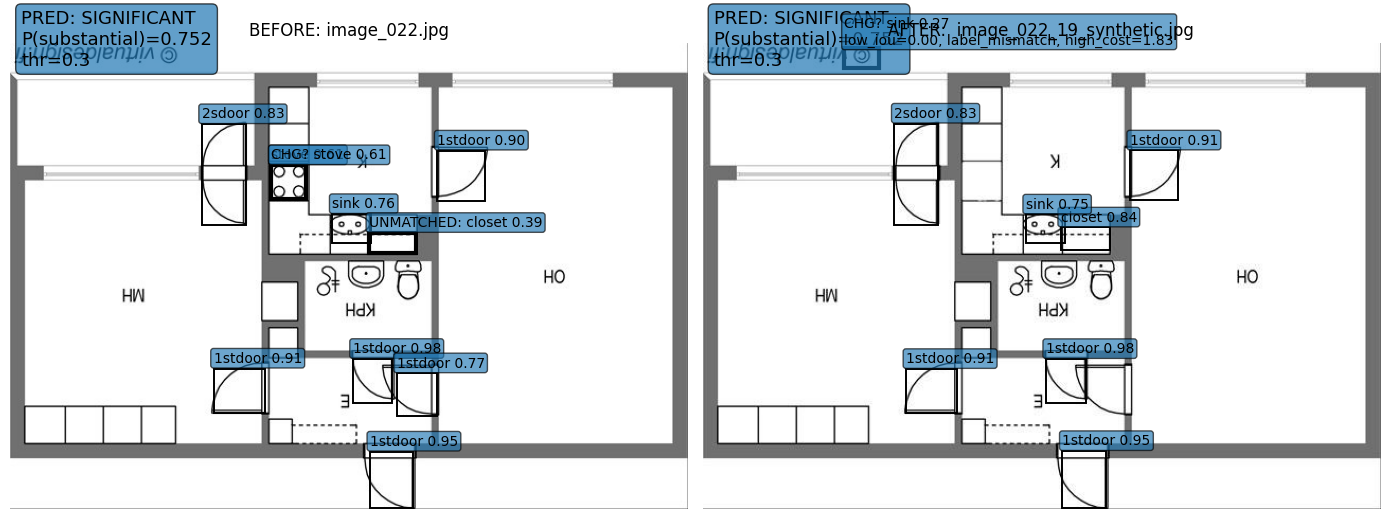

In [6]:
import os
import pickle
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import torch
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# =========================
# CONFIGURATION
# =========================

# 1. Paths relative to 'Code' folder
BEFORE = r"..\Data\images_before\image_022.jpg"
# Make sure this specific 'after' image actually exists in your folder
AFTER  = r"..\Data\images_after\substantial\remove_stove\image_022_19_synthetic.jpg"

# 2. Path to the trained classifier
TRAINED_PKL = r"..\Models\ChangeTypeClassifier\change_classifier_logreg.pkl"

# 3. Path to the DETR model
# We use abspath to prevent "Repo id" errors on Windows
DETR_MODEL_PATH = os.path.abspath(r"..\Models\detr-finetuned-floorplans")

# Decision Threshold
THRESH = 0.30

# Visualization Settings
FIGSIZE = (14, 7)
SHOW_VIZ = True
SAVE_VIZ_PATH = None 

# Draw all detections options
DRAW_ALL_DETECTIONS = True
DRAW_ALL_MIN_SCORE = 0.60

# Highlight thresholds
HIGHLIGHT_LOW_IOU = 0.20
HIGHLIGHT_HIGH_COST = 1.25

ALL_DET_LINEWIDTH = 1.4
HIGHLIGHT_LINEWIDTH = 3.0


# =========================
# Data structure
# =========================
@dataclass
class Det:
    label_id: int
    label_name: str
    score: float
    box: np.ndarray 


# =========================
# Geometry
# =========================
def xyxy_iou(a: np.ndarray, b: np.ndarray) -> float:
    ax0, ay0, ax1, ay1 = a
    bx0, by0, bx1, by1 = b
    inter_x0 = max(ax0, bx0)
    inter_y0 = max(ay0, by0)
    inter_x1 = min(ax1, bx1)
    inter_y1 = min(ay1, by1)
    iw = max(0.0, inter_x1 - inter_x0)
    ih = max(0.0, inter_y1 - inter_y0)
    inter = iw * ih
    area_a = max(0.0, ax1 - ax0) * max(0.0, ay1 - ay0)
    area_b = max(0.0, bx1 - bx0) * max(0.0, by1 - by0)
    union = area_a + area_b - inter + 1e-9
    return float(inter / union)


def bbox_center(box: np.ndarray) -> np.ndarray:
    x0, y0, x1, y1 = box
    return np.array([(x0 + x1) / 2.0, (y0 + y1) / 2.0], dtype=np.float32)


# =========================
# DETR wrapper
# =========================
class DetrWrapper:
    def __init__(self, model_path: str, device: str):
        self.device = device
        print(f"Loading DETR from: {model_path}")
        self.processor = DetrImageProcessor.from_pretrained(model_path)
        self.model = DetrForObjectDetection.from_pretrained(model_path).to(device).eval()
        self.id2label: Dict[int, str] = self.model.config.id2label

    @torch.no_grad()
    def detect(self, image_path: str, thresh: float, top_k: int) -> Tuple[List[Det], Tuple[int, int]]:
        img = Image.open(image_path).convert("RGB")
        w, h = img.size

        inputs = self.processor(images=img, return_tensors="pt").to(self.device)
        outputs = self.model(**inputs)

        target_sizes = torch.tensor([[h, w]], device=self.device)
        res = self.processor.post_process_object_detection(
            outputs, threshold=0.0, target_sizes=target_sizes
        )[0]

        scores = res["scores"].detach().cpu().numpy()
        labels = res["labels"].detach().cpu().numpy()
        boxes = res["boxes"].detach().cpu().numpy()

        keep = np.where(scores >= thresh)[0]
        if keep.size == 0:
            return [], (w, h)

        keep = keep[np.argsort(scores[keep])[::-1]]
        keep = keep[:top_k]

        dets: List[Det] = []
        for i in keep:
            lid = int(labels[i])
            dets.append(
                Det(
                    label_id=lid,
                    label_name=str(self.id2label.get(lid, lid)),
                    score=float(scores[i]),
                    box=boxes[i].astype(np.float32),
                )
            )
        return dets, (w, h)


# =========================
# Hungarian + features
# =========================

def build_cost_matrix(
    dets_a: List[Det],
    dets_b: List[Det],
    img_wh: Tuple[int, int],
    label_mismatch_penalty: float,
    center_dist_penalty: float,
) -> np.ndarray:
    w, h = img_wh
    diag = (w**2 + h**2) ** 0.5 + 1e-9

    A = len(dets_a)
    B = len(dets_b)
    if A == 0 or B == 0:
        return np.zeros((A, B), dtype=np.float32)

    cost = np.zeros((A, B), dtype=np.float32)
    for i, da in enumerate(dets_a):
        ca = bbox_center(da.box)
        for j, db in enumerate(dets_b):
            iou = xyxy_iou(da.box, db.box)
            base = 1.0 - iou
            label_pen = 0.0 if da.label_id == db.label_id else label_mismatch_penalty
            cb = bbox_center(db.box)
            center_dist = float(np.linalg.norm(ca - cb) / diag)
            center_pen = center_dist_penalty * center_dist
            cost[i, j] = base + label_pen + center_pen
    return cost


def hungarian_match(
    dets_a: List[Det],
    dets_b: List[Det],
    img_wh: Tuple[int, int],
    label_mismatch_penalty: float,
    center_dist_penalty: float,
):
    A, B = len(dets_a), len(dets_b)
    if A == 0 and B == 0:
        return [], list(range(A)), list(range(B)), np.zeros((0, 0), dtype=np.float32)
    if A == 0:
        return [], list(range(A)), list(range(B)), np.zeros((0, B), dtype=np.float32)
    if B == 0:
        return [], list(range(A)), list(range(B)), np.zeros((A, 0), dtype=np.float32)

    cost = build_cost_matrix(dets_a, dets_b, img_wh, label_mismatch_penalty, center_dist_penalty)
    r, c = linear_sum_assignment(cost)
    matches = list(zip(r.tolist(), c.tolist()))

    matched_a = set(r.tolist())
    matched_b = set(c.tolist())
    un_a = [i for i in range(A) if i not in matched_a]
    un_b = [j for j in range(B) if j not in matched_b]
    return matches, un_a, un_b, cost


def extract_pair_features(
    dets_before: List[Det],
    dets_after: List[Det],
    img_wh: Tuple[int, int],
    label_mismatch_penalty: float,
    center_dist_penalty: float,
) -> Tuple[np.ndarray, Dict[str, Any]]:
    matches, un_bef, un_aft, cost = hungarian_match(
        dets_before, dets_after, img_wh, label_mismatch_penalty, center_dist_penalty
    )

    if len(matches) > 0:
        ious = []
        label_mismatch = 0
        for i, j in matches:
            iou = xyxy_iou(dets_before[i].box, dets_after[j].box)
            ious.append(iou)
            if dets_before[i].label_id != dets_after[j].label_id:
                label_mismatch += 1
        ious = np.array(ious, dtype=np.float32)
        mean_iou = float(ious.mean())
        min_iou = float(ious.min())
        mean_cost = float(np.mean([cost[i, j] for (i, j) in matches]))
        mismatch_frac = float(label_mismatch / max(1, len(matches)))
    else:
        mean_iou = 0.0
        min_iou = 0.0
        mean_cost = 1.0
        mismatch_frac = 1.0

    denom = float(max(len(dets_before), len(dets_after), 1))
    sum_iou = 0.0
    for i, j in matches:
        sum_iou += xyxy_iou(dets_before[i].box, dets_after[j].box)
    global_sim = float(sum_iou / denom)

    unmatched_ratio = float((len(un_bef) + len(un_aft)) / denom)

    feats = np.array(
        [global_sim, mean_iou, min_iou, mean_cost, mismatch_frac, unmatched_ratio],
        dtype=np.float32,
    )

    # Extra debug for visualization
    dbg = {
        "matches": matches,
        "unmatched_before": un_bef,
        "unmatched_after": un_aft,
        "cost": cost,
    }
    return feats, dbg


# =========================
# Visualization
# =========================
def _draw_box(ax, box_xyxy, text: str, linewidth: float):
    x0, y0, x1, y1 = box_xyxy
    rect = Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, linewidth=linewidth)
    ax.add_patch(rect)
    if text:
        ax.text(
            x0, max(0, y0 - 6),
            text,
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.2", alpha=0.65),
        )


def visualize(
    before_path: str,
    after_path: str,
    pred: int,
    prob: float,
    det_b: List[Det],
    det_a: List[Det],
    match_dbg: Dict[str, Any],
):
    img_b = Image.open(before_path).convert("RGB")
    img_a = Image.open(after_path).convert("RGB")

    fig = plt.figure(figsize=FIGSIZE)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.imshow(img_b)
    ax2.imshow(img_a)
    ax1.axis("off")
    ax2.axis("off")

    ax1.set_title(f"BEFORE: {os.path.basename(before_path)}")
    ax2.set_title(f"AFTER:  {os.path.basename(after_path)}")

    pred_text = "SIGNIFICANT" if pred == 1 else "NON-SIGNIFICANT"

    ax1.text(10, 20, f"PRED: {pred_text}\nP(substantial)={prob:.3f}\nthr={THRESH}",
             fontsize=13, bbox=dict(boxstyle="round,pad=0.3", alpha=0.7))
    ax2.text(10, 20, f"PRED: {pred_text}\nP(substantial)={prob:.3f}\nthr={THRESH}",
             fontsize=13, bbox=dict(boxstyle="round,pad=0.3", alpha=0.7))

    # Draw all detections (light)
    if DRAW_ALL_DETECTIONS:
        for d in det_b:
            if d.score >= DRAW_ALL_MIN_SCORE:
                _draw_box(ax1, d.box, f"{d.label_name} {d.score:.2f}", linewidth=ALL_DET_LINEWIDTH)
        for d in det_a:
            if d.score >= DRAW_ALL_MIN_SCORE:
                _draw_box(ax2, d.box, f"{d.label_name} {d.score:.2f}", linewidth=ALL_DET_LINEWIDTH)

    # Highlight change evidence: unmatched
    for i in match_dbg["unmatched_before"]:
        d = det_b[i]
        _draw_box(ax1, d.box, f"UNMATCHED: {d.label_name} {d.score:.2f}", linewidth=HIGHLIGHT_LINEWIDTH)

    for j in match_dbg["unmatched_after"]:
        d = det_a[j]
        _draw_box(ax2, d.box, f"UNMATCHED: {d.label_name} {d.score:.2f}", linewidth=HIGHLIGHT_LINEWIDTH)

    # Highlight suspicious matches (low IoU / label mismatch / high cost)
    cost = match_dbg["cost"]
    for (i, j) in match_dbg["matches"]:
        db = det_b[i]
        da = det_a[j]
        iou = xyxy_iou(db.box, da.box)
        c = float(cost[i, j]) if cost is not None and cost.size > 0 else 0.0

        reasons = []
        if iou < HIGHLIGHT_LOW_IOU:
            reasons.append(f"low_iou={iou:.2f}")
        if db.label_id != da.label_id:
            reasons.append("label_mismatch")
        if c > HIGHLIGHT_HIGH_COST:
            reasons.append(f"high_cost={c:.2f}")

        if reasons:
            _draw_box(ax1, db.box, f"CHG? {db.label_name} {db.score:.2f}", linewidth=HIGHLIGHT_LINEWIDTH)
            _draw_box(ax2, da.box, f"CHG? {da.label_name} {da.score:.2f}\n{', '.join(reasons)}", linewidth=HIGHLIGHT_LINEWIDTH)

    plt.tight_layout()
    if SAVE_VIZ_PATH:
        os.makedirs(os.path.dirname(SAVE_VIZ_PATH), exist_ok=True)
        plt.savefig(SAVE_VIZ_PATH, dpi=150, bbox_inches="tight")
        print("Saved visualization to:", SAVE_VIZ_PATH)

    if SHOW_VIZ:
        plt.show()
    else:
        plt.close(fig)


# =========================
# Main
# =========================
def main():
    if not os.path.exists(TRAINED_PKL):
        raise FileNotFoundError(f"Trained model not found at: {TRAINED_PKL}")
    if not os.path.exists(BEFORE):
        raise FileNotFoundError(f"BEFORE image not found at: {BEFORE}")
    if not os.path.exists(AFTER):
        raise FileNotFoundError(f"AFTER image not found at: {AFTER}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("DEVICE:", device)

    # Load trained model bundle
    with open(TRAINED_PKL, "rb") as f:
        bundle = pickle.load(f)

    clf = bundle["clf"]
    
    # -----------------------------------------------------------
    # CRITICAL FIX: Override path from pickle with current config
    # -----------------------------------------------------------
    detr_model_path = DETR_MODEL_PATH
    # -----------------------------------------------------------
    
    detr_thresh = float(bundle["detr_thresh"])
    top_k = int(bundle["top_k"])
    feature_names = bundle.get("feature_names", None)

    print("Loaded PKL:", TRAINED_PKL)
    print("DETR Model Path:", detr_model_path)
    print("DETR_THRESH:", detr_thresh, "TOP_K:", top_k)
    if feature_names:
        print("Features:", feature_names)

    # IMPORTANT: these must match training parameters
    label_mismatch_penalty = 0.8
    center_dist_penalty = 0.15

    detr = DetrWrapper(detr_model_path, device=device)

    # Detect
    det_b, wh_b = detr.detect(BEFORE, thresh=detr_thresh, top_k=top_k)
    det_a, wh_a = detr.detect(AFTER,  thresh=detr_thresh, top_k=top_k)
    img_wh = wh_b

    # Features
    feats, match_dbg = extract_pair_features(
        det_b, det_a, img_wh,
        label_mismatch_penalty=label_mismatch_penalty,
        center_dist_penalty=center_dist_penalty,
    )

    prob = float(clf.predict_proba(feats.reshape(1, -1))[0, 1])
    pred = 1 if prob >= THRESH else 0

    print("\nP(substantial) =", prob)
    print("THRESH =", THRESH)
    print("PRED =", pred, "=>", "SIGNIFICANT" if pred == 1 else "NON-SIGNIFICANT")
    print("Features vector =", feats.tolist())

    # Visual
    visualize(BEFORE, AFTER, pred, prob, det_b, det_a, match_dbg)


if __name__ == "__main__":
    main()